# Decision tree

In [38]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Load and prepare data

In [22]:
df = pd.read_csv('data/bmd_prep.csv')

target_var = 'fracture'
vars_to_exclude = ['medication']

y = df[target_var]
X = df.drop(columns=[target_var]+vars_to_exclude)

## 1. Create and train a tree

In [28]:
fracture_labels = ['no fracture', 'fracture']

# Encode categorical data
X_encoded = pd.get_dummies(X)
y_encoded = y.replace(fracture_labels, [0, 1])

# Split data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.25, random_state=0)

params = {
    'max_depth': 3,
    'min_samples_split': 5,
    'max_leaf_nodes': 10
}

tree = DecisionTreeClassifier(**params)

# Fits the decision tree to training data
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10, min_samples_split=5)

### Plot the tree

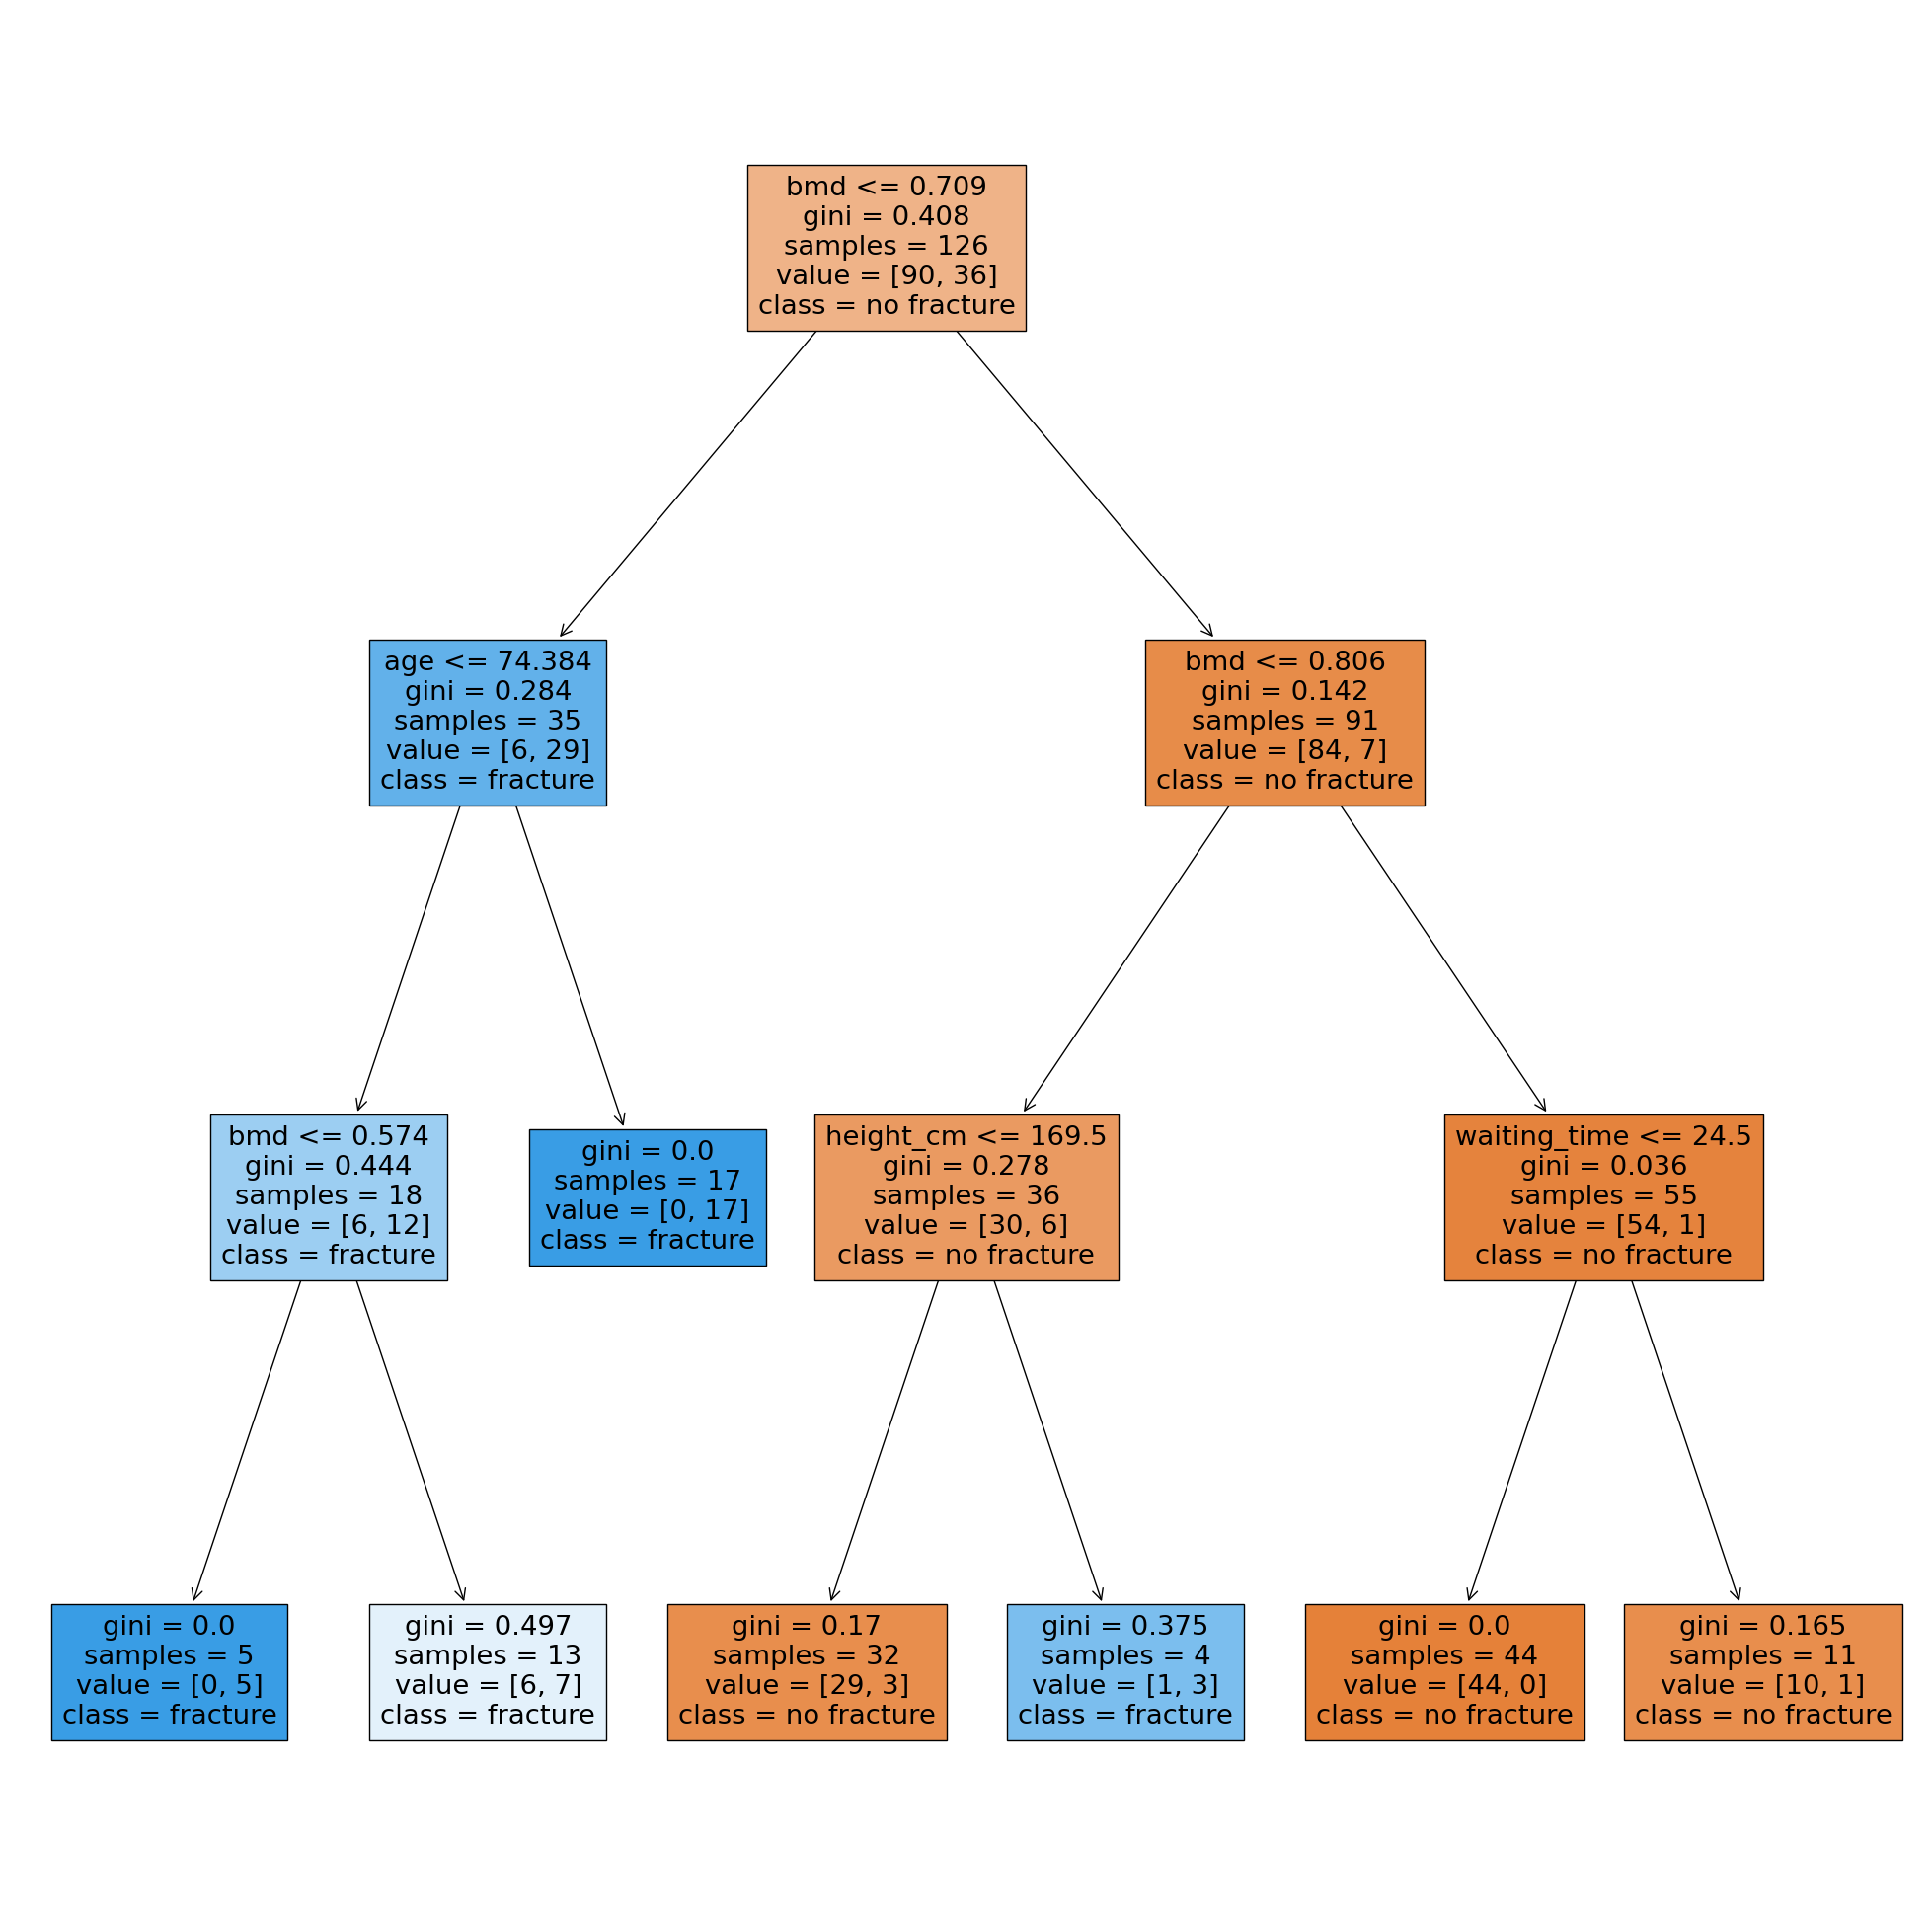

In [30]:
fig = plt.figure(figsize=(25, 25))

# Creates a visual display of the model.
# Keep max_depth small for better visualization 
t = plot_tree(
    tree,
    feature_names=X_encoded.columns,
    class_names=fracture_labels,
    filled=True)

## 2. Feature importance

In [31]:
features = X_encoded.columns.tolist()

importances_sk = tree.feature_importances_

feature_importance = []
for i, feature in enumerate(features):
    feature_importance.append({'feature': feature,'importance': round(importances_sk[i], 3)})
# sort features by their importance
feature_importance = sorted(feature_importance, key=lambda d: d['importance'], reverse=True)
print(feature_importance)

[{'feature': 'bmd', 'importance': 0.858}, {'feature': 'height_cm', 'importance': 0.085}, {'feature': 'age', 'importance': 0.054}, {'feature': 'waiting_time', 'importance': 0.004}, {'feature': 'weight_kg', 'importance': 0.0}, {'feature': 'sex_F', 'importance': 0.0}, {'feature': 'sex_M', 'importance': 0.0}]


### Plot feature (predictor) importance diagram

Text(0.5, 1.0, 'Feature importance diagram')

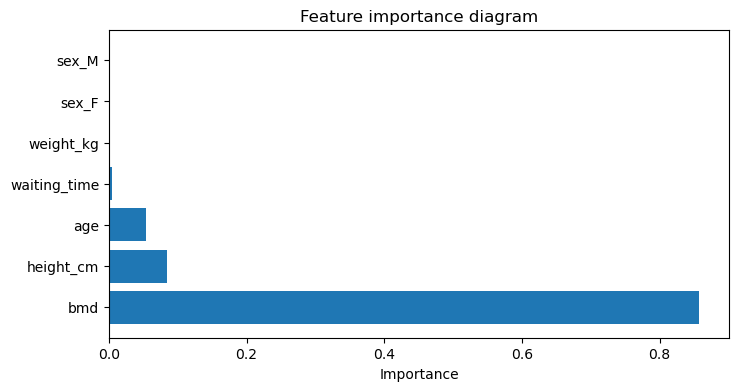

In [33]:
feature_importance_df = pd.DataFrame(columns=['feature', 'importance'])
feature_importance_df = feature_importance_df.from_records(feature_importance)

plt.figure(figsize=(8,4))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.title(f'Feature importance diagram')

Najważniejszymi predyktorami w otrzymanym drzewie są `bmd`, `height_cm` oraz `age`

## 3. Reguły dla najbardziej wyrazistych klas (liści)

1. Jeśli wskaźnik `bmd` danej osoby jest mniejszy bądź równy 0.709 oraz jej wiek (`age`) jest większy niż 75 lat, to osoba ta doznała złamania
* pewność reguły: 17/17 * 100% = `100%`
* wsparcie reguły: 17/126 * 100% = `13.5%`
2. Jeśli wskaźnik `bmd` osoby jest w przedziale (0.709, 0.806], a jej wzrost jest mniejszy bądź równy 169.5 cm, jest 90% szansy, że osoba ta nie doznała złamania
* pewność reguły: 29/32 * 100% = `90.5%`
* wsparcie reguły: 32/126 * 100% = `25.4%`
3. Jeśli wskaźnik `bmd` osoby jest większy niż 0.806, to jest ponad 98% szansy, że nie doznała ona złamania.
* pewność reguły: 54/55 * 100% = `98.2%`
* wsparcie reguły: 55/126 * 100% = `43.6%`


## 5. Confusion matrix

              precision    recall  f1-score   support

           0       0.96      0.83      0.89        29
           1       0.72      0.93      0.81        14

    accuracy                           0.86        43
   macro avg       0.84      0.88      0.85        43
weighted avg       0.88      0.86      0.86        43



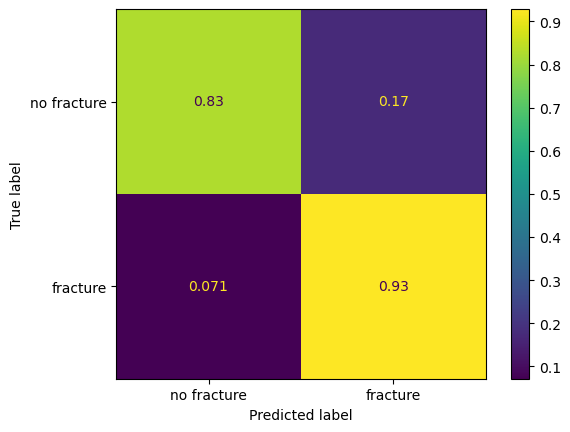

In [39]:
predictions = tree.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=tree.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fracture_labels)
disp.plot()
print(classification_report(y_test, predictions))

#### Całkowity błąd drzewa

In [36]:
print(
    'Accuracy on training data: ' 
    + str("{:.2%}".format(tree.score(X_train, y_train))))

print(
    'Accuracy on testing data: ' 
    + str("{:.2%}".format(tree.score(X_test, y_test))))

Accuracy on training data: 91.27%
Accuracy on testing data: 86.05%


## Podsumowanie

Otrzymany model drzewa cechuje się błędem na poziomie 9% dla zbioru uczącego oraz 14% dla zbioru testowego. Najważniejszym predyktorem dla zmiennej `fracture` okazuje się być wskaźnik `bmd`. Wcześniej, w ramach wstępnej analizy danych zostało stwierdzone na podstawie wykresów rozrzutu, że dla `bmd` < 0.7 większość osób doznaje złamanie, co również zostało prawidłowo określone w wygenerowanym drzewie (w korzeniu drzewa)